<h1 align="center">
<img src="https://static.propublica.org/projects/algorithmic-bias/assets/img/generated/opener-b-crop-1200*675-00796e.jpg" width="400">
<br>Study Case: The COMPAS Dataset
<h4 align="center">Technical Risks in Machine Learning Models</h2>
</h1>


The COMPAS dataset is a dataset that includes criminal records and demographic information of individuals assessed by the [COMPAS (Correctional Offender Management Profiling for Alternative Sanctions)](https://doc.wi.gov/Pages/AboutDOC/COMPAS.aspx) risk assessment tool. The data contains information on individuals' criminal history, recidivism, and demographic attributes, which has been widely analyzed to evaluate the fairness and accuracy of risk assessments. This dataset has been utilized in studies focused on bias detection and mitigation in machine learning, especially regarding racial biases in predictive policing.

**(Goal)** The primary goal of working with the COMPAS dataset is to evaluate and mitigate potential biases within predictive models used for assessing recidivism risk. By analyzing the dataset, the aim is to determine whether the model’s predictions are influenced by sensitive attributes like race, gender, and age, and to develop techniques to promote fairness. This includes the exploration of various bias mitigation algorithms, such as pre-processing, in-processing, and post-processing approaches, with a particular emphasis on maintaining predictive accuracy while enhancing the equity of model outcomes.

**(Features)** The following table presents the 16 features of Compas dataset, inclusing the target variable  "two_year_recid".


| Feature                  | Description                                                                                      |
|--------------------------|--------------------------------------------------------------------------------------------------|
| `age`                    | Age of the individual at the time of the assessment.                                             |
| `c_charge_degree`        | Degree of the charge (e.g., 'M' for misdemeanor, 'F' for felony).                                |
| `race`                   | Race of the individual (e.g., African-American, Caucasian).                                      |
| `age_cat`                | Categorical age group (e.g., 'Less than 25', '25 - 45', 'Greater than 45').                      |
| `score_text`             | Risk level as categorized by COMPAS (e.g., 'Low', 'Medium', 'High').                             |
| `sex`                    | Gender of the individual (e.g., Male, Female).                                                   |
| `priors_count`           | Number of prior offenses committed by the individual.                                            |
| `days_b_screening_arrest`| Days between arrest and screening date.                                                          |
| `decile_score`           | COMPAS risk score on a scale from 1 to 10.                                                       |
| `juv_fel_count`          | Count of juvenile felony offenses.                                                               |
| `juv_misd_count`         | Count of juvenile misdemeanor offenses.                                                          |
| `juv_other_count`        | Count of other juvenile offenses.                                                                |
| `v_type_of_assessment`   | Type of assessment for violent recidivism risk (e.g., 'Risk of Violence').                      |
| `c_days_from_compas`     | Days since the COMPAS assessment was completed.                                                  |
| `v_score_text`           | Categorical violent risk level as assessed by COMPAS (e.g., 'Low', 'Medium', 'High').           |
| `v_decile_score`         | COMPAS decile score specific to violent recidivism risk.                                         |
| `(target) two_year_recid`      | Binary indicator of whether the individual was rearrested within two years of the screening date.     |


### Load Dataset

In [2]:
from holisticai.datasets import load_dataset

dataset = load_dataset("compas_two_year_recid", protected_attribute="sex")
split_dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = split_dataset['train']
test = split_dataset['test']

## 1. Train a Binary Classification Model

In [6]:
from sklearn.ensemble import RandomForestClassifier
from holisticai.utils import BinaryClassificationProxy

model = RandomForestClassifier()

model.fit(train['X'], train['y'])

proxy = BinaryClassificationProxy(predict=model.predict, predict_proba=model.predict_proba)

## 2. Measuring Efficacy

Efficacy metrics are used to evaluate the performance of a model by quantifying how accurately it makes predictions.

## a) Accuracy

**Accuracy** is a metric that measures the proportion of correct predictions made by a classification model out of the total predictions. It is a commonly used metric for model evaluation, especially when the classes are balanced.

### Formula

Accuracy is defined as:

$$
\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Predictions}}
$$

where:
- **True Positives (TP)**: Correct positive predictions.
- **True Negatives (TN)**: Correct negative predictions.
- **Total Predictions** $= \text{True Positives} + \text{True Negatives} + \text{False Positives} + \text{False Negatives}$.

### Interpretation

- **Accuracy = 1**: The model predicts all outcomes correctly.
- **Accuracy < 1**: The model has some incorrect predictions.

Accuracy is useful when the class distribution is balanced. However, it can be misleading if the data is imbalanced, as it does no


In [7]:
from sklearn.metrics import accuracy_score

y_test_pred = proxy.predict(test['X'])
accuracy_score(test['y'], y_test_pred)

0.6510121457489878

## b) F1 Score

The **F1 Score** is a metric that combines both precision and recall into a single score. It is especially useful for evaluating the performance of a classification model when there is an imbalance in the class distribution, as it balances the trade-off between false positives and false negatives.

### Formula

The F1 Score is the harmonic mean of precision and recall and is defined as:

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

where:
- **Precision**: The ratio of correctly predicted positive observations to total predicted positives.

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall**: The ratio of correctly predicted positive observations to all actual positives.

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

### Interpretation

- **F1 Score = 1**: Perfect precision and recall.
- **F1 Score = 0**: Model fails to identify any true positives.
  
A higher F1 Score indicates better

In [4]:
from sklearn.metrics import f1_score

f1_score(test['y'], y_test_pred)

0.587360594795539

What other efficacy metrics do we have for binary classification? Holistic AI library allows you to perform a practical inspection of the metrics by calling ```classification_efficacy_metrics```:

In [5]:
from holisticai.efficacy.metrics import classification_efficacy_metrics

classification_efficacy_metrics(test['y'], y_test_pred)

,Value,Reference
Metric,,
Accuracy,0.640486,1
Balanced Accuracy,0.633962,1
Precision,0.603053,1
Recall,0.572464,1
F1-Score,0.587361,1


# 2. Measuring Bias

In machine learning fairness, Equal Opportunity and Equal Outcomes are distinct concepts:

- **Equal Opportunity**: Ensures individuals with similar qualifications have equal chances of positive outcomes, focusing on equal true positive rates across groups.

- **Equal Outcomes**: Aims for equal proportions of positive results among different demographic groups, regardless of individual qualifications.

## a) Disparate Impact

**Disparate Impact** is a fairness metric used to measure the relative rate of favorable outcomes between an unprivileged group and a privileged group. It is commonly used to assess whether a model’s predictions disproportionately favor one group over another. A value close to 1 indicates fairness, while values significantly above or below 1 indicate potential bias.

### Formula

$$
\text{Disparate Impact} = \frac{P(\text{positive outcome | unprivileged})}{P(\text{positive outcome | privileged})}
$$

where:
- $P(\text{positive outcome | unprivileged})$ is the probability of a positive outcome for the unprivileged group.
- $P(\text{positive outcome | privileged})$ is the probability of a positive outcome for the privileged group.


### Interpretation

- **Disparate Impact ≈ 1**: The model is fair (similar outcomes for both groups).
- **< 1**: The privileged group has a higher rate of positive outcomes.
- **> 1**: The unprivileged group has a higher rate of positive outcomes.

In practice, a common threshold for fairness is that **Disparate Impact should be between 0.8 and 1.25**. If the metric falls outside this range, the model may be considered biased.

In [6]:
from holisticai.bias.metrics import disparate_impact

disparate_impact(test['group_a'], test['group_b'], y_test_pred)

1.5133810207688907

## b) Equal Opportunity Difference

The **Equal Opportunity Difference** is a fairness metric that measures the difference in true positive rates (TPR) between privileged and unprivileged groups in a classification model. Ideally, this difference should be close to zero to ensure fairness.

### Formula

$$
\text{Equal Opportunity Difference} = TPR_{privileged} - TPR_{unprivileged}
$$

### Interpretation

- **0**: The model is fair (Equal Opportunity).
- **Positive**: The privileged group has a higher chance of a positive prediction.
- **Negative**: The unprivileged group has a higher chance of a positive prediction.

In [7]:
from holisticai.bias.metrics import equal_opportunity_diff

equal_opportunity_diff(test['group_a'], test['group_b'], y_test_pred, test['y'])

0.1722962503873567

You can access all bias metrics for binary classification available in the HolisticAI library using the ```classification_bias_metrics``` function.

In [8]:
from holisticai.bias.metrics import classification_bias_metrics

classification_bias_metrics(test['group_a'], test['group_b'], y_test_pred, test['y'])

,Value,Reference
Metric,,
Statistical Parity,0.154226,0
Disparate Impact,1.513381,1
Four Fifths Rule,0.660772,1
Cohen D,0.314466,0
2SD Rule,4.359618,0
Equality of Opportunity Difference,0.172296,0
False Positive Rate Difference,0.103999,0
Average Odds Difference,0.138148,0
Accuracy Difference,-0.006978,0


# Measuring Explainability

Model interpretability can be quantified through various criteria that assess how understandable a model is, as well as through transparent surrogate models that aim to represent the actual model and its decision-making process. Some criteria include:

- **Concentration of Feature Importance**: Evaluating how feature importance is distributed across the model.

- **Consistency of Feature Importance Ranking**: Assessing the stability of feature importance rankings across different decision groups within the model, such as classes 0 and 1 in binary classification.

- **Stability of Feature Importance Across the Dataset**: Analyzing how feature importance varies throughout the dataset.

- **Complexity of Feature Relationships**: Examining the complexity of the relationship between features and their partial dependence plots.

Another approach to quantifying interpretability is to evaluate how effectively a transparent model fits the actual model. For instance, if the surrogate model is a decision tree, additional measures such as tree depth or the number of features used by the transparent model can be considered.

In this tutorial, we will calculate certain model features that will assist in evaluating interpretability metrics.

In [9]:
from holisticai.inspection import compute_permutation_importance
from holisticai.utils.surrogate_models import create_surrogate_model
from holisticai.inspection import compute_partial_dependence
from holisticai.inspection import compute_conditional_permutation_importance


# Feature Importance
importance = compute_permutation_importance(proxy, X=train['X'], y=train['y'])
top_importance = importance.top_alpha()
top_feature_names = top_importance.feature_names

# Conditional Feature Importance
conditional_impotance = compute_conditional_permutation_importance(proxy, X=test['X'], y=test['y'])

# Partial Dependence
X_sample = test['X'].sample(1000)
partial_dependence = compute_partial_dependence(features=top_feature_names, proxy=proxy, X=X_sample)

# Surrogate Model
surrogate_model = create_surrogate_model(X=train['X'], y_pred=train['y'], surrogate_type='tree', learning_task='classification')

Measuring Alpha  Score that represents the percentage of features that represent the 80% of importnaces in the model behaivours. A lower value points that we can explain the model decision with few features.

In [10]:
from holisticai.explainability.metrics.global_feature_importance import alpha_score

alpha_score(importance)

0.4

Measuring Fluctuation Ratio points the percentage in the PDP curve that present fluctuation in the model prediction.

In [11]:
from holisticai.explainability.metrics.global_feature_importance import fluctuation_ratio

fluctuation_ratio(partial_dependence)

0.06685125

Rank Alignment estima a porcentagem de features que permancem alineados no top of importances for label 0 and label 1

In [12]:
from holisticai.explainability.metrics.global_feature_importance import rank_alignment

rank_alignment(conditional_impotance, top_importance)

0.3653846153846154

Global Feature Importance Based Metrics

In [13]:
from holisticai.explainability.metrics import classification_global_feature_importance_explainability_metrics

classification_global_feature_importance_explainability_metrics(partial_dependence, importance, conditional_impotance)

,Value,Reference
Spread Divergence,0.454325,1
Fluctuation Ratio,0.066851,0
Rank Alignment,0.428571,1
Alpha Score,0.4,0


Tree based Metrics

In [14]:
from holisticai.explainability.metrics import tree_explainability_metrics

tree_explainability_metrics(surrogate_model)

,value,reference
metric,,
Weighted Average Depth,15.531976,0.0
Weighted Average Explainability Score,11.207445,0.0
Weighted Gini Index,0.699632,0.0
Tree Depth Variance,20.405185,0.0
Number of Rules,1352.000000,1.0
Number of Features,18.000000,1.0


Surrogate Based Metrics

In [15]:
from holisticai.explainability.metrics import classification_surrogate_explainability_metrics

y_pred = proxy.predict(test['X'])
classification_surrogate_explainability_metrics(test['X'], test['y'], y_pred, surrogate_model)

,Value,Reference
Accuracy Degradation,0.049223,0
Surrogate Fidelity,0.79919,1
Surrogate Feature Stability,0.926316,1


# Measuring Security

Security metrics in machine learning evaluate the robustness and resilience of models against threats to data privacy, model integrity, and information leakage. They provide insight into how susceptible a model is to various risks and guide strategies to safeguard sensitive information and maintain reliable performance.

Here’s a brief description of each type of security metric in the library:

- **SHAPR**: This metric assesses membership privacy risk by estimating how much individual training data points influence model predictions. By using Shapley values, SHAPR quantifies the likelihood of data memorization, which can reveal vulnerabilities to membership inference attacks.

- **Data Minimizer**: Similar to feature selection methods, Data Minimizer evaluates the model’s performance as features are iteratively removed. By identifying features that have minimal impact on model accuracy, it highlights areas where data minimization can improve privacy without sacrificing effectiveness.

- **Privacy Risk Score**: This metric quantifies the risk of exposure for each data record within the model, typically by estimating the likelihood that an adversary could infer whether a specific record was part of the training data. Privacy Risk Score helps prioritize sensitive data points for potential mitigation strategies, ensuring that high-risk records are better protected.

In [16]:
from holisticai.security.metrics import shapr_score

y_pred_train = proxy.predict(train['X'])
y_pred_test = proxy.predict(test['X'])

shapr_score(train['y'], test['y'], y_pred_train, y_pred_test, train_size=0.4)

array([[ 8.1197602e-01, -7.8640449e-01,  1.2785778e-02, ...,
         8.1012701e-04,  8.1012701e-04,  0.0000000e+00],
       [ 8.3767611e-01, -7.6070446e-01,  3.8485873e-02, ...,
         8.0971658e-04,  8.0971658e-04,  8.0971658e-04],
       [ 8.3767611e-01, -7.6070446e-01,  3.8485873e-02, ...,
         8.0971658e-04,  8.0971658e-04,  8.0971658e-04],
       ...,
       [ 8.1197602e-01, -7.8640449e-01,  1.2785778e-02, ...,
         8.1012701e-04,  8.1012701e-04,  0.0000000e+00],
       [-8.3686644e-01,  7.6151407e-01, -3.7676156e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.1197602e-01, -7.8640449e-01,  1.2785778e-02, ...,
         8.1012701e-04,  8.1012701e-04,  0.0000000e+00]], dtype=float32)

In [17]:
from holisticai.security.commons import DataMinimizer
from holisticai.security.metrics import data_minimization_score

dmin = DataMinimizer(proxy=proxy, selector_types=["Percentile", "Variance"])
dmin.fit(train['X'], train['y'])

y_pred_test = proxy.predict(test['X'])
y_pred_test_dm = dmin.predict(test['X'])


data_minimization_score(test['y'], y_pred_test, y_pred_test_dm)

/home/kcosta/.local/share/hatch/env/virtual/holisticai/6RE4VnP4/holisticai/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/kcosta/.local/share/hatch/env/virtual/holisticai/6RE4VnP4/holisticai/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/kcosta/.local/share/hatch/env/virtual/holisticai/6RE4VnP4/holisticai/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/kcosta/.local/share/hatch/env/virtual/holisticai/6RE4VnP4/holisticai/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in d

0.978960396039604

In [18]:
from holisticai.security.metrics import privacy_risk_score

target_shadow = train.train_test_split(test_size=0.4, random_state=42)

X_shadow_train = target_shadow['test']['X']
y_shadow_train = target_shadow['test']['y']

shadow_model = RandomForestClassifier(random_state=42)
shadow_model.fit(X_shadow_train, y_shadow_train)

shadow_train_probs = shadow_model.predict_proba(X_shadow_train)
shadow_test_probs = shadow_model.predict_proba(test['X'])
target_test_probs = proxy.predict_proba(test['X'])

risk_score_test = privacy_risk_score((shadow_train_probs, y_shadow_train), (shadow_test_probs, test['y']), (target_test_probs, test['y']))
print("Mean Privacy Risk Score for test: ", risk_score_test.mean(), risk_score_test.std())

Mean Privacy Risk Score for test:  0.4568734634681075 0.15002356864007632


# Measuring Robustness

Robustness metrics are measures used to evaluate how well machine learning models maintain performance under varying conditions, such as data shifts, adversarial inputs, or environmental changes. These metrics help assess a model’s resilience and reliability in real-world applications.


Accuracy Degradation Factor (ADF) is a robustness metric that detects the first point of significant accuracy drop as a dataset is gradually reduced, allowing for the prediction of performance shifts due to changing data distributions. Here is an exampel how to use the metric:

In [13]:
from holisticai.robustness.metrics import (
    accuracy_degradation_profile,
    accuracy_degradation_factor,
)
import pandas as pd

results = accuracy_degradation_profile(test['X'], 
                                    test['y'], 
                                    y_test_pred, 
                                    n_neighbors = 50,
                                    step_size = 0.02,
                                    )
accuracy_degradation_factor(pd.DataFrame(results.data))

0.78

## Extra Example: Bias-Accuracy Tradeoff

In [26]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from holisticai.bias.metrics import equal_opportunity_diff, statistical_parity, disparate_impact

In [21]:
models = {
    'LR_l2': LogisticRegression(penalty='l2', C=1.0, solver='liblinear'),
    'LR_l1': LogisticRegression(penalty='l1', C=1.0, solver='liblinear'),
    'RF_50': RandomForestClassifier(n_estimators=50),
    'RF_100': RandomForestClassifier(n_estimators=100),
    'RF_150': RandomForestClassifier(n_estimators=150),
    'DT_5': DecisionTreeClassifier(max_depth=5),
    'DT_10': DecisionTreeClassifier(max_depth=10),
    'DT_15': DecisionTreeClassifier(max_depth=15),
}

scores, eq_opp, disp_imp, stat_parity  = [], [], [], []
for model_name, model in models.items():
    model = model
    model.fit(train['X'], train['y'])
    pred = model.predict(test['X'])
    score = accuracy_score(test['y'], pred)
    
    eod = equal_opportunity_diff(test['group_a'], test['group_b'], pred, test['y'])
    di = disparate_impact(test['group_a'], test['group_b'], pred)
    sp = statistical_parity(test['group_a'], test['group_b'], pred)
   
    scores.append(score)
    eq_opp.append(eod)
    disp_imp.append(di)
    stat_parity.append(sp)

In [25]:
tab_df = pd.DataFrame({'Model': list(models.keys()), 'Error': scores, 'Equal Opportunity Difference': eq_opp, 'Disparate Impact': disp_imp, 'Statistical Parity': stat_parity}) 
corr = tab_df.iloc[:,1:].corr()
corr

,Error,Equal Opportunity Difference,Disparate Impact,Statistical Parity
Error,1.000000,0.944610,0.857902,0.738124
Equal Opportunity Difference,0.944610,1.000000,0.944339,0.831064
Disparate Impact,0.857902,0.944339,1.000000,0.965946
Statistical Parity,0.738124,0.831064,0.965946,1.000000


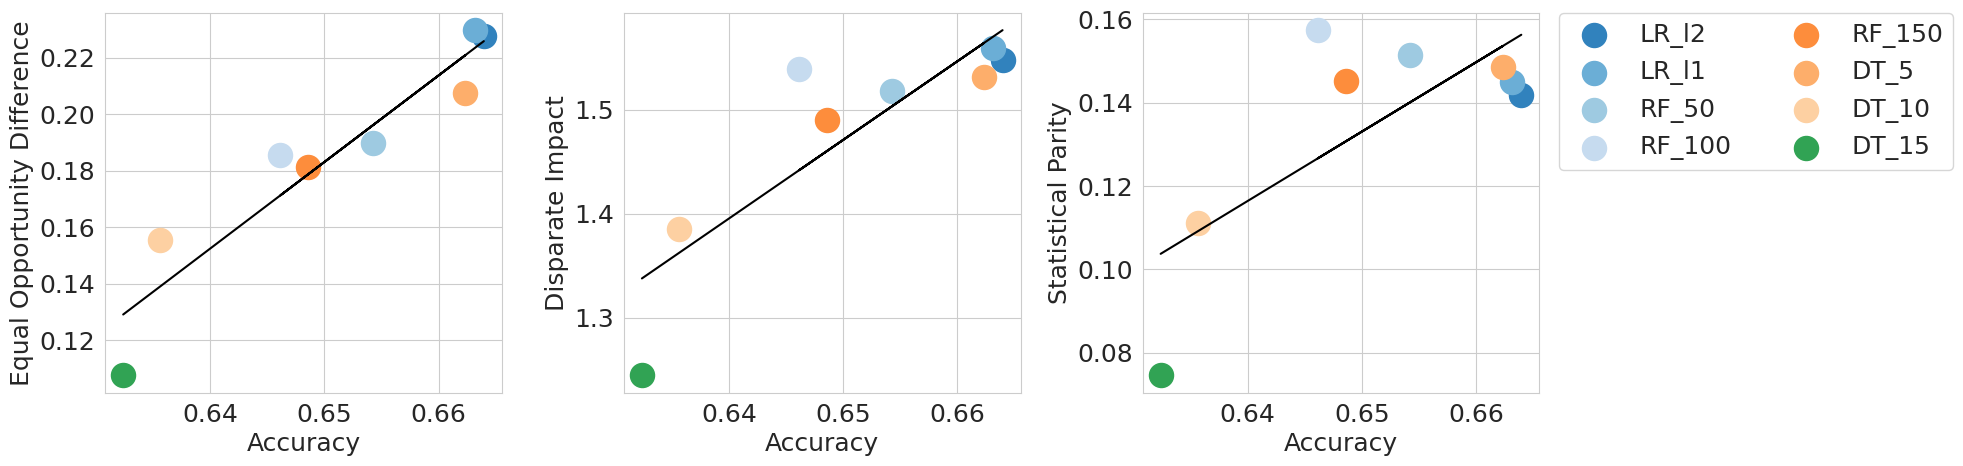

In [29]:
# font size
FONT_SIZE = 18

# set font size
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

NUM_COLORS = 16
cm = plt.get_cmap('tab20c')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))  # Adjust nrows and ncols based on your needs

for i, col in enumerate(['Equal Opportunity Difference', 'Disparate Impact', 'Statistical Parity']):
    axs[i].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    for j, model in enumerate(tab_df['Model']):
        axs[i].scatter(tab_df['Error'][j], tab_df[col][j], s=300, label=model)
    z = np.polyfit(tab_df['Error'], tab_df[col], 1)
    p = np.poly1d(z)
    axs[i].plot(tab_df['Error'], p(tab_df['Error']), "black")

    axs[i].set_xlabel('Accuracy')
    axs[i].set_ylabel(col)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)
plt.tight_layout()
plt.show()